Connected to Python 3.12.2

Accuracy: 0.93
Precision: 0.95
Recall: 0.90
Specificity: 0.95
F1 Score: 0.92


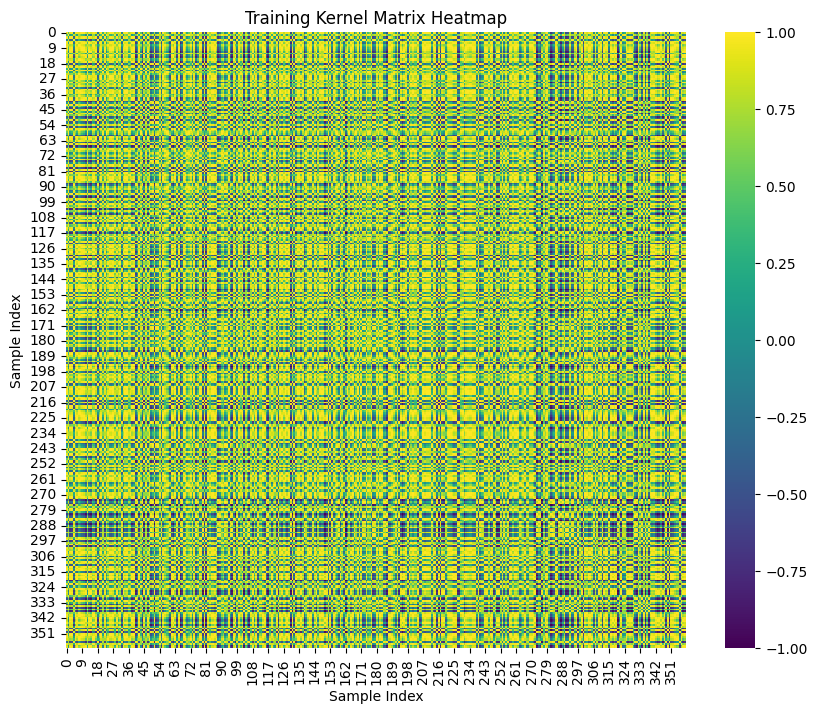

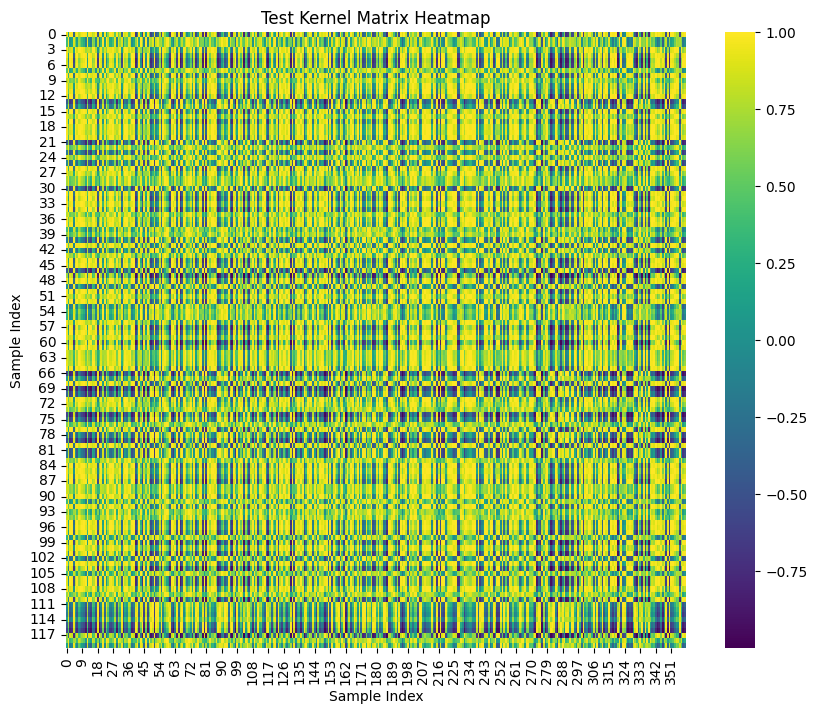

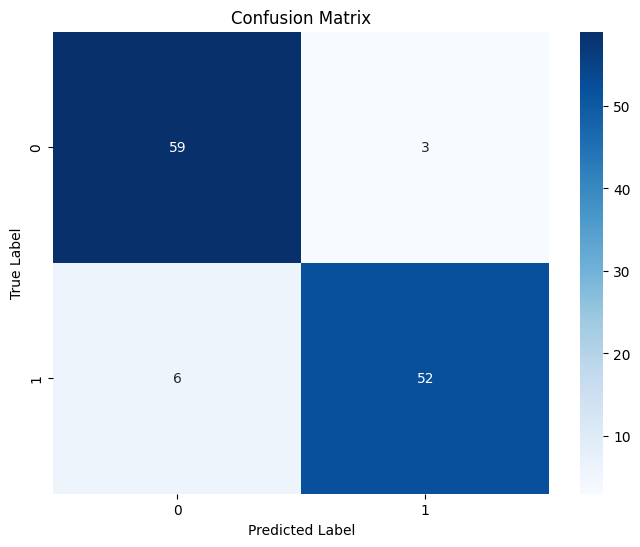

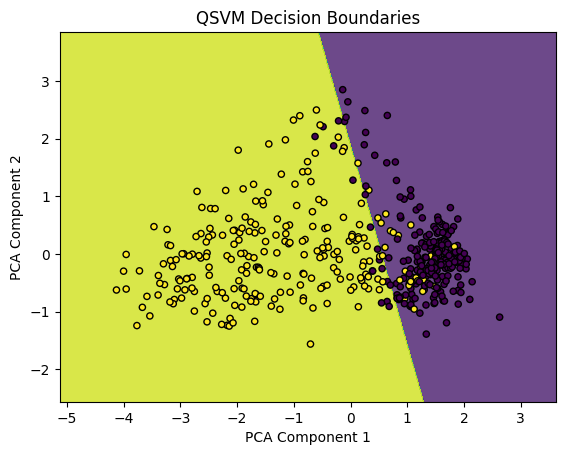

In [ ]:
import pandas as pd
import numpy as np
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Define the function to fetch and preprocess data
def fetch_data_random_seed_val(n_samples, seed):
    dataset = pd.read_csv('pulsar.csv')

    data0 = dataset[dataset[dataset.columns[8]] == 0]
    data0 = data0.sample(n=n_samples, random_state=seed)
    X0 = data0[data0.columns[0:8]].values
    Y0 = data0[data0.columns[8]].values

    data1 = dataset[dataset[dataset.columns[8]] == 1]
    data1 = data1.sample(n=n_samples, random_state=seed)
    X1 = data1[data1.columns[0:8]].values
    Y1 = data1[data1.columns[8]].values

    X = np.append(X0, X1, axis=0)
    Y = np.append(Y0, Y1, axis=0)

    min_max_scaler = MinMaxScaler(feature_range=(0, np.pi))
    X = min_max_scaler.fit_transform(X)

    # Split into training+validation and testing datasets
    train_val_X, test_X, train_val_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=seed)
    
    # Split the training+validation set into training and validation sets
    train_X, validation_X, train_Y, validation_Y = train_test_split(train_val_X, train_val_Y, test_size=0.25, random_state=seed)

    return train_X, validation_X, test_X, train_Y, validation_Y, test_Y

# Define the quantum device
dev = qml.device("lightning.qubit", wires=8)

# Define the quantum circuit
@qml.qnode(dev)
def quantum_kernel(x1, x2):
    qml.templates.AngleEmbedding(x1, wires=range(8))
    qml.adjoint(qml.templates.AngleEmbedding)(x2, wires=range(8))
    return qml.expval(qml.PauliZ(0))

# Compute the quantum kernel matrix
def quantum_kernel_matrix(X1, X2):
    return np.array([[quantum_kernel(x1, x2) for x2 in X2] for x1 in X1])

# Main code
n_samples = 300
seed = 42

# Fetch and preprocess data
train_X, validation_X, test_X, train_Y, validation_Y, test_Y = fetch_data_random_seed_val(n_samples, seed)

# Compute the quantum kernel matrices
K_train = quantum_kernel_matrix(train_X, train_X)
K_test = quantum_kernel_matrix(test_X, train_X)

# Train the QSVM
svm = SVC(kernel='precomputed')
svm.fit(K_train, train_Y)

# Make predictions
y_pred = svm.predict(K_test)

# Calculate accuracy
accuracy = accuracy_score(test_Y, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(test_Y, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

# Calculate precision, recall, specificity, and F1 Score
precision = precision_score(test_Y, y_pred)
recall = recall_score(test_Y, y_pred)
specificity = tn / (tn + fp)  # Specificity = TN / (TN + FP)
f1 = f1_score(test_Y, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the heatmap for the training kernel matrix
plt.figure(figsize=(10, 8))
sns.heatmap(K_train, cmap='viridis')
plt.title('Training Kernel Matrix Heatmap')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
#plt.savefig('QSVM_traning_kernel_matrix_heatmap.png')
plt.show()

# Plot the heatmap for the test kernel matrix
plt.figure(figsize=(10, 8))
sns.heatmap(K_test, cmap='viridis')
plt.title('Test Kernel Matrix Heatmap')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
#plt.savefig('QSVM_testing_kernel_matrix_heatmap.png')
plt.show()

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot the classification boundaries
def plot_decision_boundaries(X, y, model, title='Decision Boundaries'):
    # Reduce data to 2D using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # Train model on PCA-transformed data
    model.fit(X_pca, y)
    
    # Create a mesh to plot the decision boundaries
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    #plt.savefig('QSVM_decision_boundaries.png')
    plt.show()

# Use a linear SVM for the decision boundary plot
linear_svm = SVC(kernel='linear')
plot_decision_boundaries(np.vstack((train_X, test_X)), np.hstack((train_Y, test_Y)), linear_svm, title='QSVM Decision Boundaries')

Restarted Python 3.12.2